In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
from keras import backend as K
import gc
from skimage import color, filters, measure, io

In [ ]:
labels = ["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"]
path = "/content/drive/MyDrive/Exudates"

In [ ]:
inpshape = (300,300)

In [ ]:
data = pd.read_csv(path+'/trainLabels_cropped.csv')
data.shape

data.head(10)

,Unnamed: 0.1,Unnamed: 0,image,level
0,0,0,10_left,0
1,1,1,10_right,0
2,2,2,13_left,0
3,3,3,13_right,0
4,4,4,15_left,1
5,5,5,15_right,2
6,6,6,16_left,4
7,7,7,16_right,4
8,8,8,17_left,0
9,9,9,17_right,1


In [ ]:
from random import randint
data = data.sample(frac=1, random_state=randint(0,1000000000)).reset_index(drop=True)

In [ ]:
dx = []
dy = []
dxval = []
dyval = []

In [ ]:
take = [122]*5
take

[122, 122, 122, 122, 122]

In [ ]:
import os
print(os.path.exists('/content/drive/MyDrive/Exudates/resized_train_cropped'))

True


In [ ]:
for i in tqdm(np.array(data)):
    if take[i[3]] > 0:
        file_path = f"/content/drive/MyDrive/Exudates/resized_train_cropped/{i[2]}.jpeg"
        if os.path.exists(file_path):
            img = cv2.resize(cv2.imread(file_path),inpshape)[:,:,::-1]/255

            if (take[i[3]]>101):
              dxval.append(img)
              dyval.append(i[3])
            else:
              dx.append(img)
              dy.append(i[3])
            take[i[3]] -= 1
            if np.sum(take) <=0:
                break

100%|██████████| 6890/6890 [06:17<00:00, 18.23it/s]


In [ ]:
xval = np.array(dxval)
yval = np.array(dyval)
x = np.array(dx)
y = np.array(dy)
print(np.unique(y,return_counts=1))
print(np.unique(yval,return_counts=1))

(array([0, 1, 2, 3, 4]), array([113, 113, 113, 112,  90]))
(array([0, 1, 2, 3, 4]), array([21, 21, 21, 21, 21]))


In [ ]:
x.shape , y.shape

((541, 300, 300, 3), (541,))

Moderate


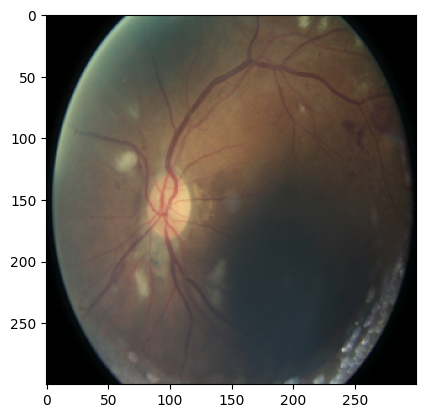

In [ ]:
i = 0
plt.imshow(x[i])
print(labels[y[i]])
i+=1

In [ ]:
def segmentImg(img):
    microaneurysm_threshold = 0.5
    microaneurysm_min_area = 5
    microaneurysm_max_area = 100
    exudate_threshold = 0.7
    exudate_min_area = 20
    exudate_max_area = 500

    # Convert the image to grayscale
    gray_image = color.rgb2gray(img)

    # Apply Gaussian blur to reduce noise
    blurred = filters.gaussian(gray_image, sigma=1)

    # Microaneurysm detection
    microaneurysm_binary_image = blurred > microaneurysm_threshold
    microaneurysm_labeled_image, num_microaneurysms = measure.label(microaneurysm_binary_image, connectivity=2, return_num=True)

    # Exudate detection
    exudate_binary_image = blurred > exudate_threshold
    exudate_labeled_image, num_exudates = measure.label(exudate_binary_image, connectivity=2, return_num=True)

    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')

    # Mark microaneurysms
    for region in measure.regionprops(microaneurysm_labeled_image):
        yp, xp = region.centroid
        circle = plt.Circle((xp, yp), 2, color='r', fill=False)
        ax.add_patch(circle)

    # Mark exudates
    for region in measure.regionprops(exudate_labeled_image):
        yp, xp = region.centroid
        circle = plt.Circle((xp, yp), 2, color='b', fill=False)
        ax.add_patch(circle)

    plt.title(f"Segmented Image")
    plt.show()

    # Generate a basic report
    print("Detection Report:")
    print(f"  Microaneurysms Detected: {num_microaneurysms}")
    print(f"  Exudates Detected: {num_exudates}")

In [ ]:
import tensorflow as tf
import keras
from keras import layers
from keras.models import Sequential
from keras.applications import DenseNet201
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator


In [ ]:

# Create a dataset from the numpy arrays
dataset = tf.data.Dataset.from_tensor_slices((x, y))

# Shuffle the dataset
dataset_train = dataset.shuffle(buffer_size=len(x))

dataset_val = tf.data.Dataset.from_tensor_slices((xval, yval))

In [ ]:
BATCH_SIZE = 20

train_generator = ImageDataGenerator(
        rotation_range=5,
        zoom_range=[0.7,1],
        brightness_range=[.8,1.2],
        horizontal_flip=True,
    )

In [ ]:
def preprocess_function(image, label):
  # Perform any desired preprocessing operations on the image and label.
  # For example, you could resize the image or normalize the pixel values.
  return image, label

dataset_train = dataset_train.map(preprocess_function)
dataset_val = dataset_val.map(preprocess_function)

In [ ]:
def build_model(backbone, lr):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1920, activation='relu'))
    # model.add(layers.Dense(512, activation='sigmoid'))
    # model.add(layers.Dense(512, activation='sigmoid'))
    model.add(layers.Dense(np.unique(y).shape[0], activation='softmax'))


    model.compile(loss= tf.losses.sparse_categorical_crossentropy,
                  optimizer = tf.optimizers.Adam(learning_rate=lr),
                  metrics=["acc"])

    return model

In [ ]:
K.clear_session()
gc.collect()

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(inpshape[0],inpshape[1],3)
)


model = build_model(resnet ,lr = 4e-4)
model.summary()

74836368/74836368 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 9, 9, 1920)        18321984  
                                                                 
 global_average_pooling2d (  (None, 1920)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 1920)              7680      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 1920)              3688320   
                                                                 
 dense_1 (Dense)             (None, 5)                 9605      
                                                         

In [ ]:
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=4,verbose=1,factor=0.3, min_lr=1e-7)

!pip install -q -U keras-tuner

from tensorflow import keras
from kerastuner import HyperParameters
from tensorflow.keras.models import load_model

filepath="/content/weights_best.h5"
# Load the model
# model = load_model(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.7 MB/s eta 0:00:00


<ipython-input-22-056b115cdb46>:6: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperParameters


In [ ]:
history = model.fit(
    dataset_train.batch(BATCH_SIZE),
    epochs=30,
    validation_data=dataset_val.batch(BATCH_SIZE),
    callbacks = [learn_control, checkpoint],
)


Epoch 1/30
28/28 [==============================] - ETA: 0s - loss: 1.8721 - acc: 0.3475
Epoch 1: val_acc improved from -inf to 0.27619, saving model to /content/weights_best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 185s 1s/step - loss: 1.8721 - acc: 0.3475 - val_loss: 1.6115 - val_acc: 0.2762 - lr: 4.0000e-04
Epoch 2/30
28/28 [==============================] - ETA: 0s - loss: 1.5216 - acc: 0.4547
Epoch 2: val_acc improved from 0.27619 to 0.29524, saving model to /content/weights_best.h5
28/28 [==============================] - 23s 811ms/step - loss: 1.5216 - acc: 0.4547 - val_loss: 2.4861 - val_acc: 0.2952 - lr: 4.0000e-04
Epoch 3/30
28/28 [==============================] - ETA: 0s - loss: 1.1178 - acc: 0.6007
Epoch 3: val_acc did not improve from 0.29524
28/28 [==============================] - 17s 588ms/step - loss: 1.1178 - acc: 0.6007 - val_loss: 3.0730 - val_acc: 0.2952 - lr: 4.0000e-04
Epoch 4/30
28/28 [==============================] - ETA: 0s - loss: 0.8232 - acc: 0.6932
Epoch 4: val_acc improved from 0.29524 to 0.43810, saving model to /content/weights_best.h5
28/28 [==============================] - 23s 815ms/step - loss: 0.8232 - acc: 0.6932 - v

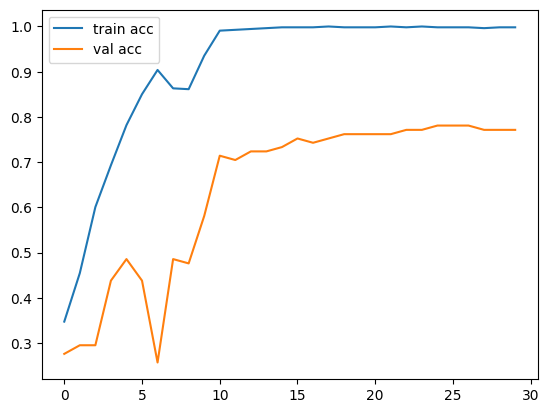

In [ ]:
plt.plot(history.history["acc"],label="train acc")
plt.plot(history.history["val_acc"],label="val acc")
plt.legend()

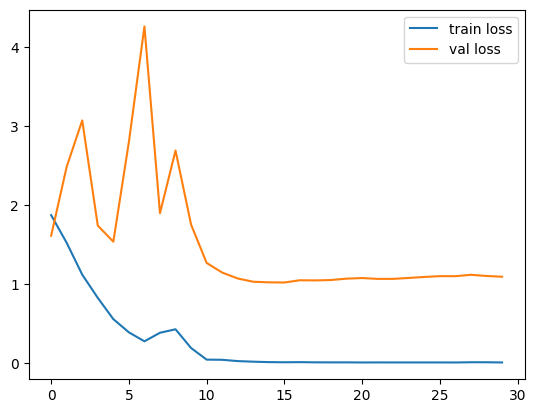

In [ ]:
plt.plot(history.history["loss"],label="train loss")
plt.plot(history.history["val_loss"],label="val loss")
plt.legend()

BLUE = **EXUDATES**

---


RED = **MICROANEURYSMS**

pred: Moderate --- actual: Moderate


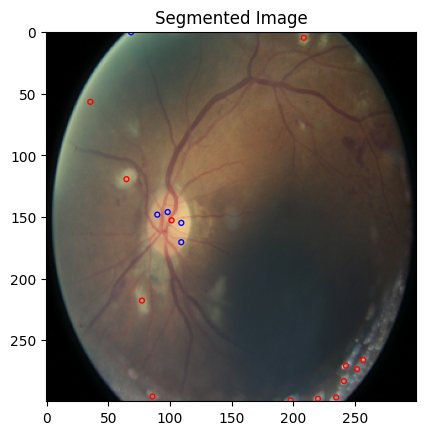

Detection Report:
  Microaneurysms Detected: 13
  Exudates Detected: 5


In [ ]:
i = 0
pred = model.predict(np.array([xval[i]]),verbose=0)
p = np.argmax(pred)
print(f"pred: {labels[p]} --- actual: {labels[yval[i]]}")
segmentImg(xval[i])
i+=1

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
p = np.argmax(model.predict(xval),axis=1)
print(confusion_matrix(yval,p))
print(classification_report(yval,p))

4/4 [==============================] - 1s 252ms/step
[[16  2  2  0  1]
 [ 4 15  2  0  0]
 [ 0  3 14  4  0]
 [ 0  0  2 18  1]
 [ 0  0  1  2 18]]
              precision    recall  f1-score   support

           0       0.80      0.76      0.78        21
           1       0.75      0.71      0.73        21
           2       0.67      0.67      0.67        21
           3       0.75      0.86      0.80        21
           4       0.90      0.86      0.88        21

    accuracy                           0.77       105
   macro avg       0.77      0.77      0.77       105
weighted avg       0.77      0.77      0.77       105



pred: Moderate --- actual: Moderate


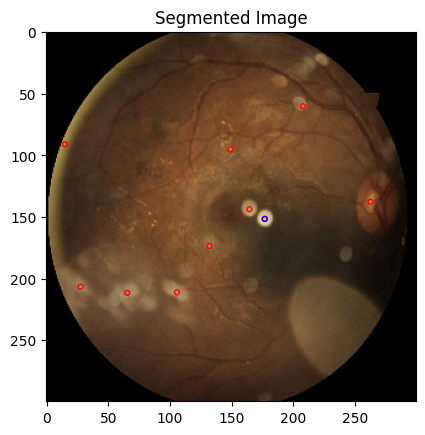

Detection Report:
  Microaneurysms Detected: 10
  Exudates Detected: 1


In [ ]:
i = 25
pred = model.predict(np.array([xval[i]]),verbose=0)
p = np.argmax(pred)
print(f"pred: {labels[p]} --- actual: {labels[yval[i]]}")
segmentImg(xval[i])
i+=1

pred: Proliferative DR --- actual: Proliferative DR


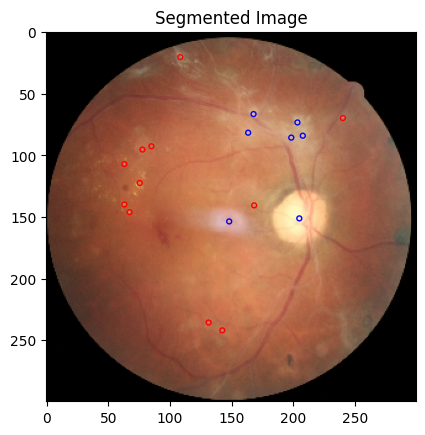

Detection Report:
  Microaneurysms Detected: 11
  Exudates Detected: 7


In [ ]:
i = 69
pred = model.predict(np.array([xval[i]]),verbose=0)
p = np.argmax(pred)
print(f"pred: {labels[p]} --- actual: {labels[yval[i]]}")
segmentImg(xval[i])
i+=1

pred: No DR --- actual: No DR


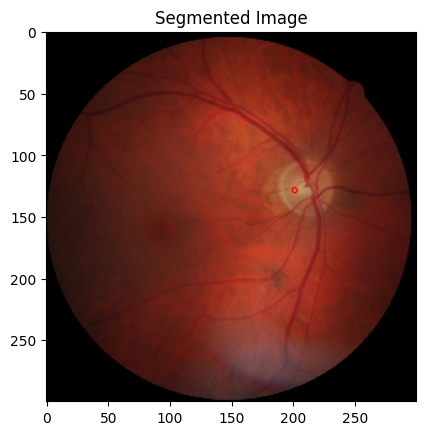

Detection Report:
  Microaneurysms Detected: 1
  Exudates Detected: 0


In [ ]:
i = 10
pred = model.predict(np.array([xval[i]]),verbose=0)
p = np.argmax(pred)
print(f"pred: {labels[p]} --- actual: {labels[yval[i]]}")
segmentImg(xval[i])
i+=1